In [1]:
# importing necessary libraries
import torch.multiprocessing as mp

# Use torch.multiprocessing instead of multiprocessing
mp.set_start_method('spawn', force=True)

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

**RESNET 18**

In [2]:
# Define ResNet-18 Model
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, reduction=16):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [3]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        self.linear = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, kernel_size=3, stride=2, padding=1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

# Data Transformations and Loading
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


CIFAR-10



100%|██████████| 170M/170M [00:03<00:00, 48.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Files already downloaded and verified
Epoch [1/20], Loss: 1.5522
Test Accuracy of the model on the 10000 test images: 51.05%
Epoch [2/20], Loss: 1.1759
Test Accuracy of the model on the 10000 test images: 62.47%
Epoch [3/20], Loss: 1.0194
Test Accuracy of the model on the 10000 test images: 65.65%
Epoch [4/20], Loss: 0.9225
Test Accuracy of the model on the 10000 test images: 69.98%
Epoch [5/20], Loss: 0.8427
Test Accuracy of the model on the 10000 test images: 72.30%
Epoch [6/20], Loss: 0.7785
Test Accuracy of the model on the 10000 test images: 73.90%
Epoch [7/20], Loss: 0.7416
Test Accuracy of the model on the 10000 test images: 73.14%
Epoch [8/20], Loss: 0.6885
Test Accuracy of the model on the 10000 test images: 76.43%
Epoch [9/20], Loss: 0.6597
Test Accuracy of the model on the 10000 test images: 76.12%
Epoch [10/20], Loss: 0.6287
Test Accuracy of the model on the 10000 test images: 75.47%
Epoch [11/20], Loss: 0.5092
Test Accuracy of the model on the 10000 test images: 81.04%
Epo

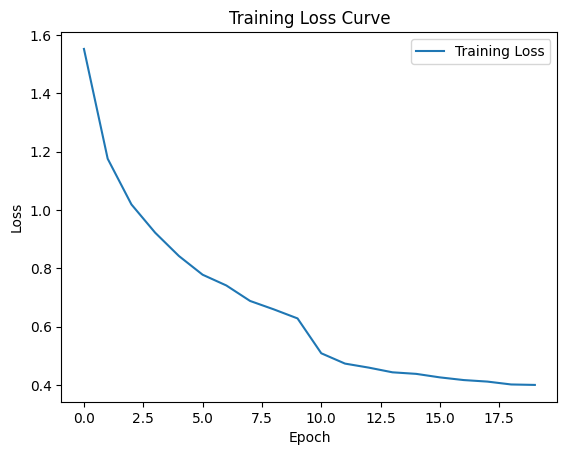

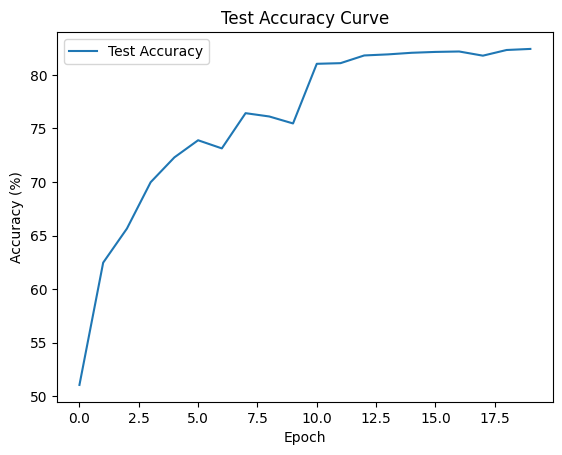

In [4]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=4)

# Training and Evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 20
train_loss_list = []
test_accuracy_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_loss_list.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

    # Test the model
    model.eval()
    correct = 0
    total = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    test_accuracy_list.append(accuracy)
    print(f'Test Accuracy of the model on the 10000 test images: {accuracy:.2f}%')

    scheduler.step()

# Calculate Final Metrics
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print Final Metrics
print("\nFinal Metrics:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot the loss curve
plt.figure()
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.figure()
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve')
plt.legend()
plt.show()

MNIST





Epoch [1/20], Loss: 0.1312
Test Accuracy of the model on the 10000 test images: 94.40%
Epoch [2/20], Loss: 0.0615
Test Accuracy of the model on the 10000 test images: 98.95%
Epoch [3/20], Loss: 0.0485
Test Accuracy of the model on the 10000 test images: 98.62%
Epoch [4/20], Loss: 0.0358
Test Accuracy of the model on the 10000 test images: 98.15%
Epoch [5/20], Loss: 0.0371
Test Accuracy of the model on the 10000 test images: 99.18%
Epoch [6/20], Loss: 0.0328
Test Accuracy of the model on the 10000 test images: 99.34%
Epoch [7/20], Loss: 0.0262
Test Accuracy of the model on the 10000 test images: 98.73%
Epoch [8/20], Loss: 0.0260
Test Accuracy of the model on the 10000 test images: 99.33%
Epoch [9/20], Loss: 0.0224
Test Accuracy of the model on the 10000 test images: 98.96%
Epoch [10/20], Loss: 0.0203
Test Accuracy of the model on the 10000 test images: 99.35%
Epoch [11/20], Loss: 0.0071
Test Accuracy of the model on the 10000 test images: 99.52%
Epoch [12/20], Loss: 0.0050
Test Accuracy

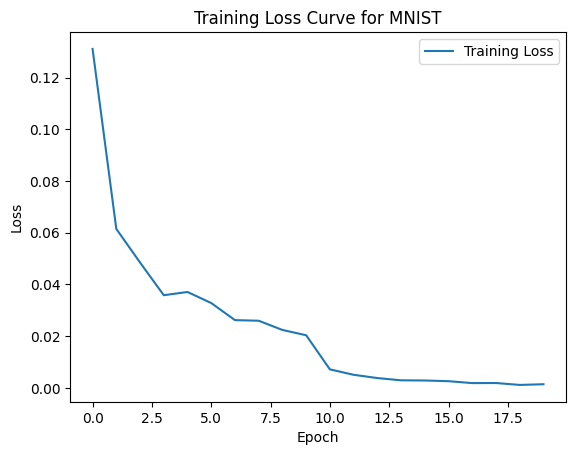

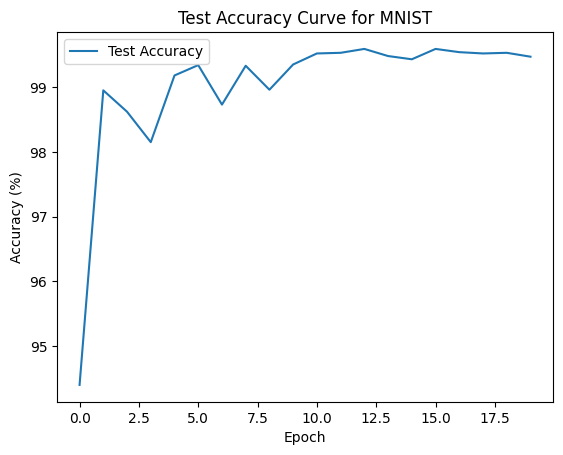

In [6]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        self.linear = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, kernel_size=3, stride=2, padding=1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

# Data Transformations and Loading for MNIST
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize for ResNet
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=4)

# Training and Evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 20
train_loss_list = []
test_accuracy_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_loss_list.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

    # Test the model
    model.eval()
    correct = 0
    total = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    test_accuracy_list.append(accuracy)
    print(f'Test Accuracy of the model on the 10000 test images: {accuracy:.2f}%')

    scheduler.step()

# Calculate Final Metrics
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print Final Metrics
print("\nFinal Metrics for MNIST:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot the loss curve
plt.figure()
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve for MNIST')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.figure()
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve for MNIST')
plt.legend()
plt.show()


FMNIST






Final Metrics for Fashion-MNIST:
Accuracy: 91.57%
Precision: 0.92
Recall: 0.92
F1 Score: 0.92


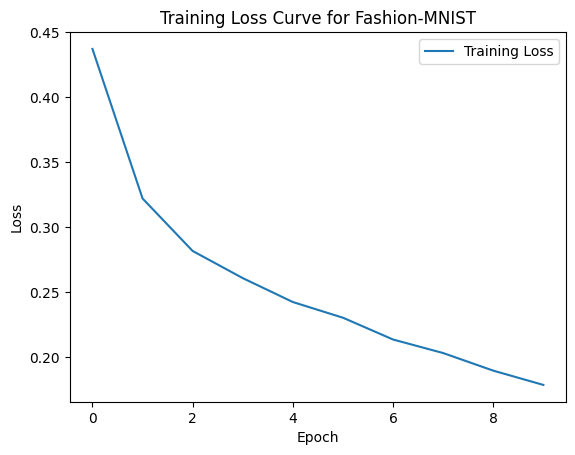

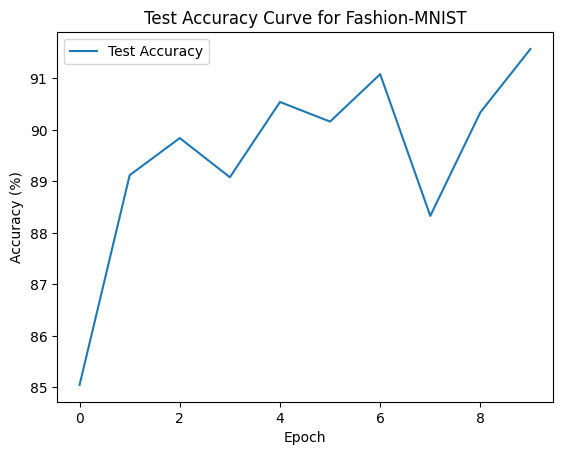

In [9]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 64, stride=1)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        self.layer4 = self._make_layer(256, 512, stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, in_planes, out_planes, stride):
        layers = [
            nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_planes)
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = nn.functional.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

# Declare the Fashion-MNIST Dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize for ResNet
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Model, Loss Function, Optimizer
model = ResNet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Evaluation
num_epochs = 10
train_loss_list = []
test_accuracy_list = []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_loss_list.append(train_loss)

    # Testing
    model.eval()
    correct = 0
    total = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    test_accuracy_list.append(accuracy)

# Final Metrics Calculation
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print Final Metrics
print("\nFinal Metrics for Fashion-MNIST:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot Training Loss Curve
plt.figure()
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve for Fashion-MNIST')
plt.legend()
plt.show()

# Plot Test Accuracy Curve
plt.figure()
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve for Fashion-MNIST')
plt.legend()
plt.show()